# CH07 합성곱 신경망(CNN)

## 7.1 전체구조

지금까지의 신경망처럼 계층을 쌓아 만들 수 있으나 **합성곱 계층**과 **풀링계층**이 새롭게 등장  
목표 : 계층들을 어떻게 조합하여 CNN을 만드는지 확인  

**완전결합**: 지금까지 본 신경망처럼 인접하는 계층의 모든 뉴런이 결합되어 있는 형태(구현에서 Affine계층에 해당)  
Affine -> ReLU -> Affine -> ReLU -> ... -> Affine -> Softmax  
이런식이었다면  

**CNN의 구조는 Conv - ReLU - Pooling 흐름**으로 연결  
Conv -> ReLU -> Pooling -> ... -> Conv -> ReLU -> Pooling -> Conv -> ReLU -> Affine -> ReLU -> Affine -> Softmax  
출력에 가까운 층에서는 지금까지의 Affine - ReLU 를 사용하고 마지막 출력 계층에서는 Affine-Softmax 조합을 그대로 사용  

## 7.2 합성곱 계층

완전연결 계층의 문제점 : 데이터의 형상이 무시됨(이미지와 같은 경우 차원 속에 담겨 있는 의미 무시)  
합성곱 신경망은 형상을 유지 (이미지도 3차원으로 입력받으며 다음계층으로 넘길때도 3차원 유지)  

CNN  
특징 맵 : 입출력 데이터  
입력특징 맵 : 합성곱 계층의 입력데이터  
출력특징 맵 : 출력 데이터

**합성곱 연산**  
합성곱 계층에서 수행  
입력데이터에 필터를 적용
둘은 각각 세로 가로 방향의 차원(높이, 너비) 가짐  

합성곱 연산은 필터의 **윈도우**를 일정 간격만큼 이동하며 입력 데이터에 적용  
입력과 필터에 대응하는 원소끼리 곱한 후 그 총합을 구함(**단일 곱셈 누산**)
결과를 해당 장소에 저장  
이 과정을 모든 장소에서 수행시 합성곱 연산의 출력   
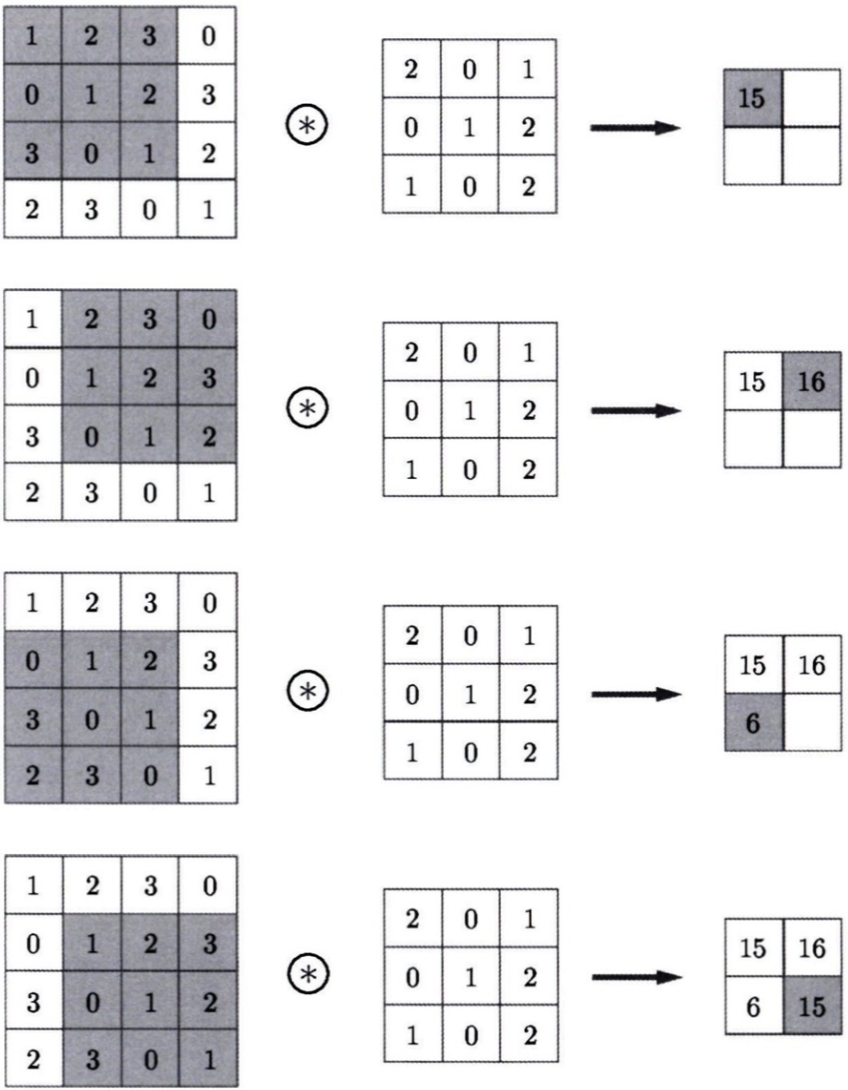  
이후에 각각 원소에 편향(1x1)을 더하면 완성

**패딩**  
합성곱 연산을 수행하기 전에 데이터 주변을 특정값(0)으로 채우기도 함  
위 그림에서 4x4입력데이터에 폭이 1인 패딩을 적용하면  
4x4데이터는 건드리지 않은채로 최외곽에 0으로 이루어진 층(패딩)을 만들어 6x6이 된다  
이러면 필터 적용시 4x4의 결괏값을 얻을 수 있음  
보통 출력 크기를 조정할 목적으로 많이 사용  

**스트라이드**  
필터를 적용하는 위치의 간격을 스트라이드라 부름  
위의 예시에서는 스트라이드가 1  
스트라이드를 키우면 출력값이 작아진다고 해석 가능  

**수식**  
입력의 크기 : $(H,W)$  
필터의 크기 : $(FH,FW)$  
출력의 크기 : $(OH,OW)$  
패딩 : $P$  
스트라이드 : $S$  
$$ \begin{cases}
OH = \frac{H + 2P - FH}{S} + 1 \\
OW = \frac{W + 2P - FW}{S} + 1
\end{cases} $$  
예를 들어 입력이 (28,31)이고 패딩이 2, 스트라이드가 3, 필터가 (5,5)라하면  
OH = 10  
OW = 11  

가능하면 정수로 딱 떨어지는 것을 지향  

**3차원 데이터의 합성곱 연산**  
특징맵이 여러개 있다면 입력 데이터와 필터의 합성곱 연산을 채널마다 수행하고 그 결과를 더해서 하나의 출력을 얻음  
주의할 점 : 입력 데이터의 채널 수와 필터의 채널 수가 같아야함  

**블록으로 생각하기**  
3차원 합성곱 연산은 데이터와 필터를 직육면체 블록이라고 가정하면 이해가 쉬움  
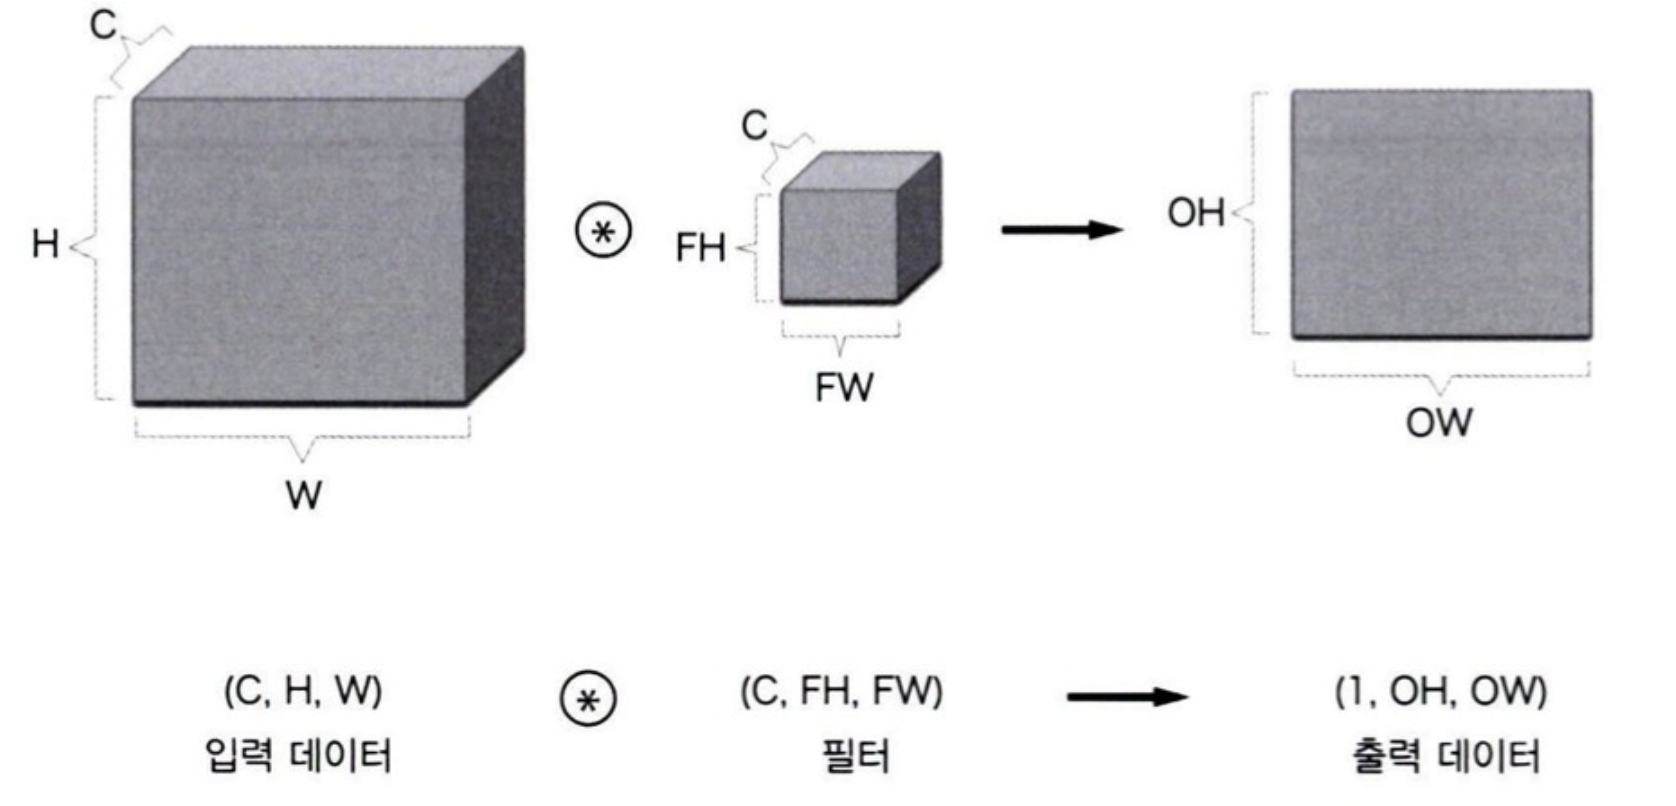  
(채널, 높이, 너비)를 가짐  

만약 출력의 채널 수를 늘리고 싶다면 필터를 다수 사용하면 됨  
이러면 필터는 4차원 데이터가 되고 출력을 3차원으로 만듦  
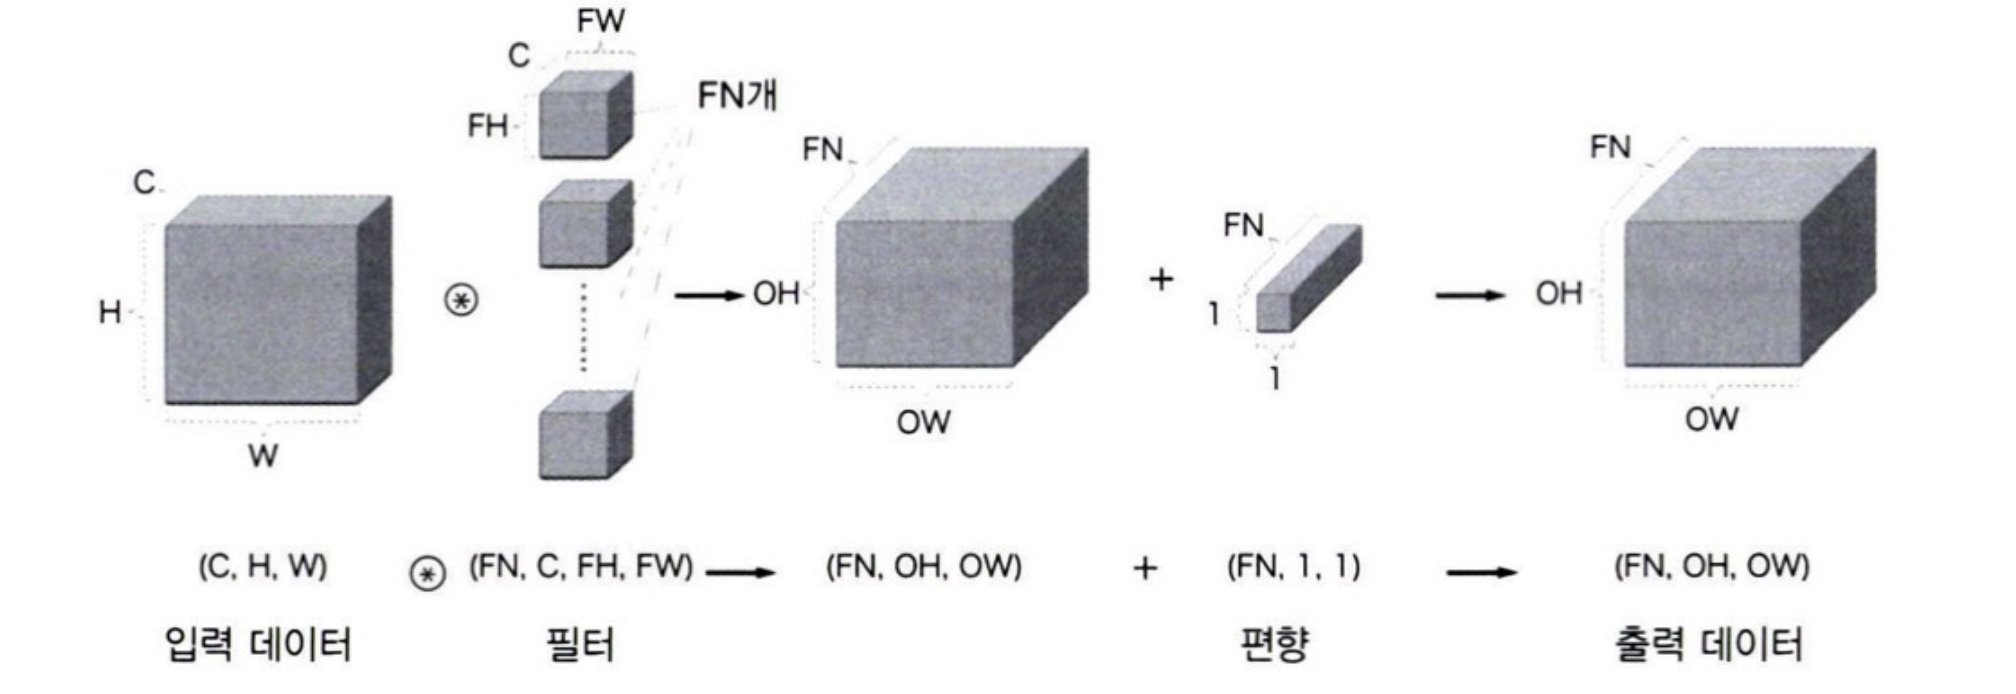

**배치처리**  
위 방향성에서 한 단계 더 나아가 입력 데이터를 N개로 늘린다고하면  
모든 계층과 데이터가 4차원으로 확장되며 논리를 그대로 사용할 수 있다

**풀링계층**  
풀링은 세로/가로 방향의 공간을 줄이는 연산  
영역을 설정해 해당 영역을 원소 하나로 집약  

최대풀링 : 최댓값을 구하는 연산. 
예를 들어 (2,2)크기를 스트라이드 2로 처리 시 (2,2) 정사각형 범우 내에서 가장 큰 값하나 꺼내고 윈도우 2칸 이동
보통(n,n)이면 스트라이드를 n으로 맞춰줌

풀링계층 특징  
* 대사영역에서 최댓값이나 평균을 취하는 명확한처리이므로 학습해야할 매개변수가 없음
* 채널별로 독립적으로 계산하기 때문에 입력데이터의 채널 수를 그대로 출력 데이터로 내보냄
* 입력의 변화에 영향을 적게 받음

## 7.4 합성곱 풀링 계층 구현

CNN에서 흐르는 데이터는 4차원  

In [1]:
import numpy as np
x = np.random.rand(10,1,28,28)
x.shape #체널 1개 높이 28 너비 28인 데이터 10개 

(10, 1, 28, 28)

이는 파이썬의 인덱스로 접근가능

In [2]:
x[0].shape #1번째 데이터

(1, 28, 28)

In [3]:
x[0,0] # 1번째 데이터의 1번째 채널

array([[5.29787975e-01, 9.23450094e-03, 4.21963897e-01, 3.96463471e-01,
        1.38915848e-01, 2.33720843e-01, 2.44526882e-01, 9.46786445e-01,
        6.85224632e-01, 2.98475253e-01, 7.01610094e-01, 8.12733736e-01,
        1.68069164e-01, 9.68752644e-01, 6.46748680e-01, 3.69151548e-01,
        5.40533686e-01, 2.16907250e-01, 9.24805829e-01, 9.89568166e-01,
        8.85135836e-01, 3.84978682e-01, 8.67891858e-01, 3.05209437e-01,
        7.88296078e-01, 5.62856279e-01, 6.71540243e-01, 8.01646350e-02],
       [2.30933555e-01, 5.17780363e-01, 8.05296274e-01, 3.46004442e-01,
        7.43381368e-01, 3.24509848e-01, 9.75135199e-01, 1.61182661e-01,
        5.67771741e-01, 9.14298752e-02, 6.48584114e-01, 9.88035440e-01,
        5.83132990e-01, 6.29686802e-02, 7.83416497e-01, 5.89482598e-01,
        4.64862677e-01, 9.37932777e-01, 1.23990841e-01, 8.35666796e-01,
        9.96570548e-01, 4.07316039e-01, 9.13988637e-01, 2.88688048e-01,
        7.85268296e-01, 3.56225809e-01, 1.66602978e-01, 3.07292

합성곱 연산은 곧이곧대로 구현하려면 for문을 겹겹이 쌓아야함  
지칫 복잡해질 수 있기에 im2col함수를 정의하여 데이터 전개  

**im2col**(image to column)  
입력데이터를 필터링(가중치 계산)하기에 좋게 전개하는 함수  
필터링하기 좋게 입력데이터 데이터를 전개함  
필터를 적용하는 3차원 블록을 한줄로 늘어놓는 연산을 모든 영역에서 수행하면 됨  
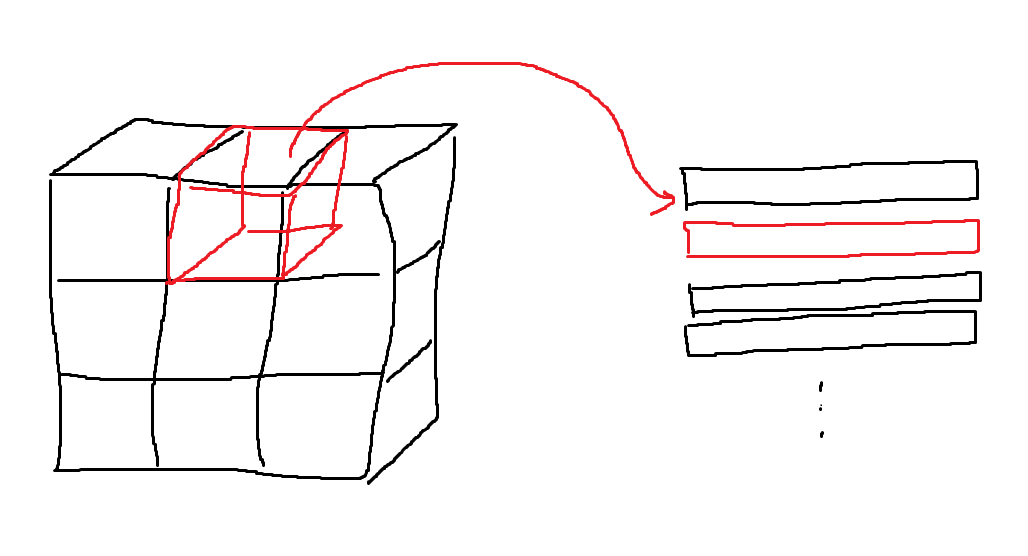

위 그림처러 스트라이드를 크게 잡아 필터의 적용영역이 겹치지 않도록하는 경우는 실제로는 별로 없음  
보통 많이 겹치기에 im2col로 전개한 후의 원소 수가 원래 블록의 원소 수 보다 많아짐  
따라서 메모리를 더 많이 소비하는 단점이 있음  
하지만 컴퓨터는 행렬연산에 빠르기에 행렬계산 라이브러리를 사용하면 큰 행렬의 곱셈을 빠르게 계산할 수 있음  
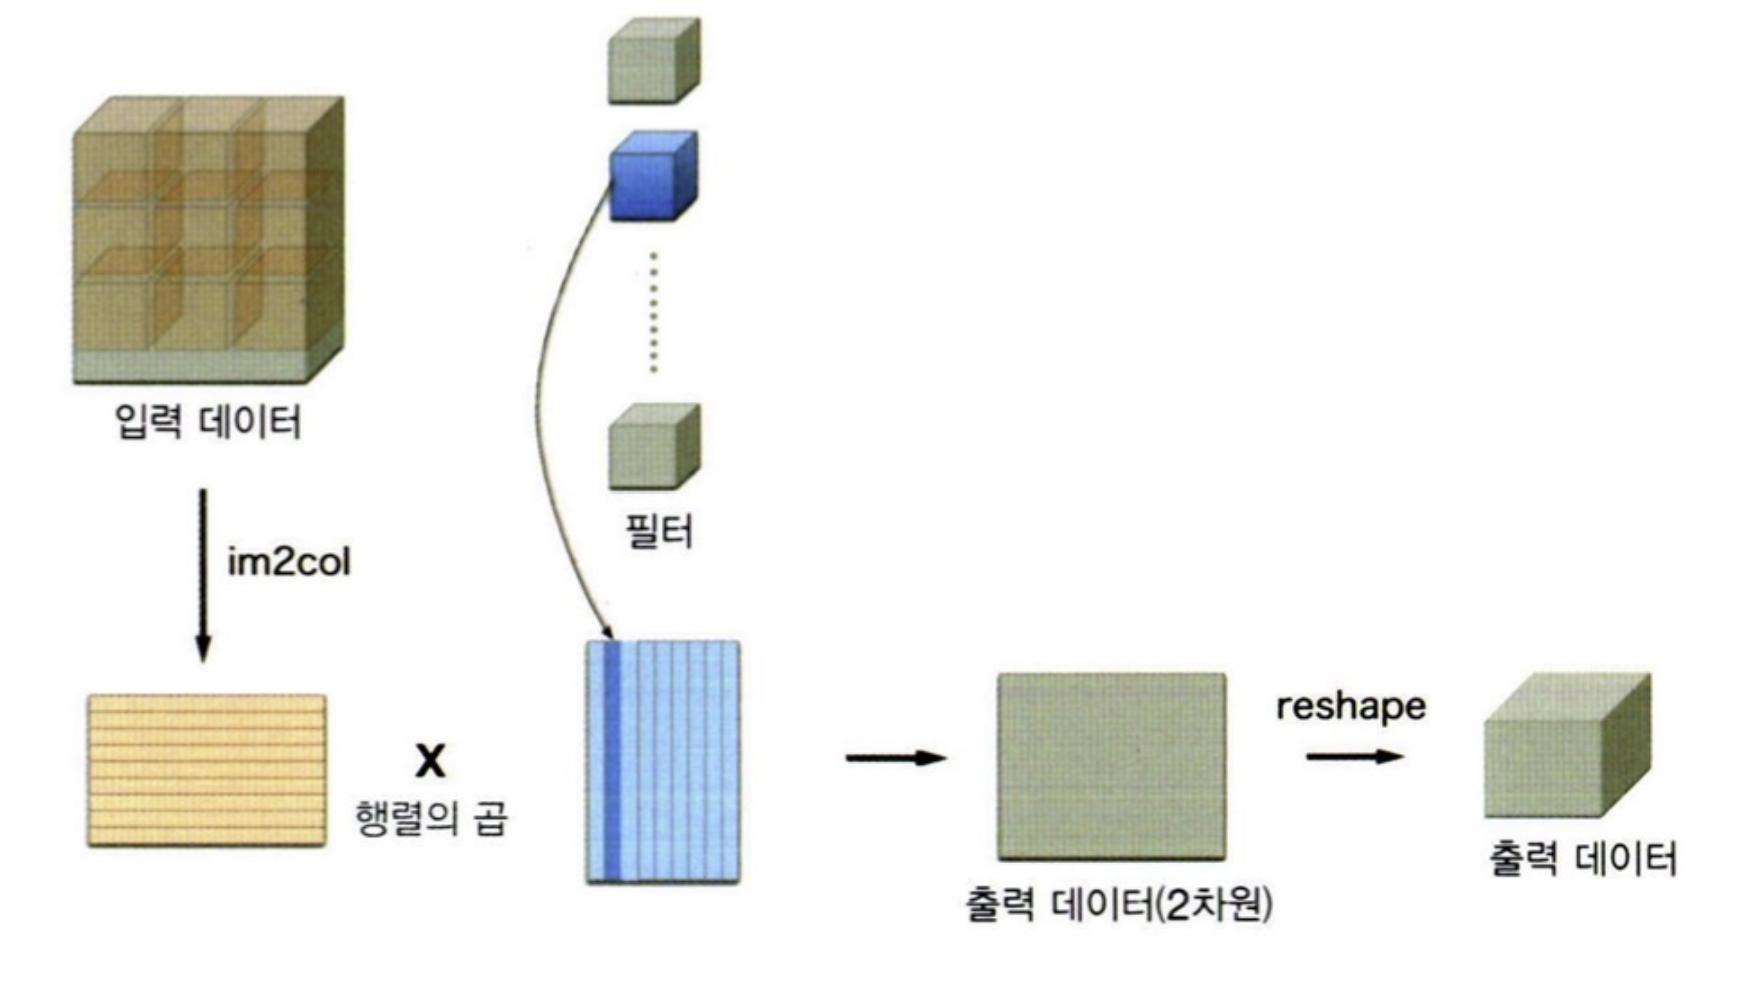

In [4]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

**파라미터 해석**  
* input_data : 4차원 배열 형태의 입력 데이터(이미지 수, 채널 수, 높이, 너비)
* filter_h : 필터의 높이
* filter_w : 필터의 너비
* stride : 스트라이드
* pad : 패딩

~~코키형님이 자꾸 코드를 다 생략해버려서 혼자서 찾아보기 힘들다ㅠㅠ~~  

**코드해석**  

    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
N, C, H, W: 입력 데이터의 모양 (데이터 개수, 채널 수, 높이, 너비)  
out_h, out_w: 필터(도장)를 다 찍고 나면 결과물이 몇 빙 몇 크기가 될지 계산하는 공식  

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
패딩(np.pad): 이미지 테두리에 0을 두르는 작업  
(N, C, H, W) 순서대로 패딩을 줌  
[ (N지시), (C지시), (H지시), (W지시) ] 이렇게 4개의 튜플이 리스트 안에 들어가 있는 형태   
데이터 개수(N)와 채널(C)에는 따로 패딩을 추가하지 않으므로(0, 0)이고  
높이(H)와 너비(W) 위아래 양옆에만 pad만큼 0을 채우라는 뜻  

    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))
나중에 깔끔하게 펴기 위해서, 임시로 데이터를 담아둘 6차원 공간  

    for y in range(filter_h):
    y_max = y + stride*out_h
    for x in range(filter_w):
        x_max = x + stride*out_w
        col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]
필터의 1번 픽셀이 찍힐 이미지의 모든 위치를 한 번에 잘라서(y:y_max:stride) 6차원 정리공간에 넣고  
그다음 2번 픽셀이 찍힐 위치를 잘라서 꽂아 넣는 방식  
for문을 최소화해서 속도를 끌어올리기 위한 넘파이 슬라이싱 꼼수  

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col  
복잡했던 데이터를 2차원 행렬로 펴버림  
-1은 나머지 원소 개수에 맞춰서 알아서 쭉 펴라는 뜻

In [5]:
x1 = np.random.rand(1,3,7,7)
col1 = im2col(x1,5,5,stride=1,pad=0)
print(col1.shape)

x2 = np.random.rand(10,3,7,7)
col2 = im2col(x2,5,5,stride=1,pad=0)
print(col2.shape)

(9, 75)
(90, 75)


    (9, 75)
25*3이 9개  

    (90, 75)
그게 또 10개

**Convolution (합성곱 계층) 구현**  

In [6]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=1):
        self.W =W
        self.b = b
        self.stride = stride
        self.pad = pad

    def forward(self, x):
        FN,C,FH,FW = self.W.shape
        N,C,H,W = x.shape
        out_h = int(1 +(H + 2*self.pad -FH) / self.stride)
        out_w = int(1 +(W + 2*self.pad -FW) / self.stride)

        col = im2col(x, FH, FW, self.stride,self.pad)
        col_W = self.W.reshape(FN, -1).T
        out = np.dot(col, col_W) + self.b

        out = out.reshape(N, out_h, out_w, -1).transpose(0,3,1,2)

        return out

    col = im2col(x, FH, FW, self.stride,self.pad)
필터가 닿을 모든 픽셀들을 잘라서 거대한 2차원 표(행렬)로 쫙 펴버림

    col_W = self.W.reshape(FN, -1).T
필터가 FN개 있음  
이 4차원짜리 필터 뭉치들을 세로로 길쭉한 1차원 막대기로 편 다음  
그것들을 transpose함으로 행으로 세워둠  
이때 transpose는 (N,H,W,C)를 (N,C,H,W)로 바꿈

    out = np.dot(col, col_W) + self.b
이미지를 편 col과 필터를 세워둔 col_W를 np.dot으로 곱해버림  
원래대로라면 필터 하나 찍을 때마다 for문 돌리면서 더하고 곱해야하는데    
모든 걸 2차원 표로 만들어 놨기 때문에 모든 데이터, 모든 위치의 합성곱 계산이 한 번에 끝나버림  
마지막에 편향 추가  